<a href="https://colab.research.google.com/github/ovsienkobohdan/ecg-classification/blob/master/cnn_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
import pandas as pd
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
import matplotlib.pyplot as plt

In [0]:
np.random.seed(7)

In [0]:
number_of_classes = 4

In [0]:
def bool_to_dec_array(bool_array):  # Encoding labels
    dec_array = np.zeros((np.shape(bool_array)[0]))
    for i in range(np.shape(bool_array)[0]):
        max_value = max(bool_array[i, :])
        max_index = list(bool_array[i, :]).index(max_value)
        dec_array[i] = max_index
    return dec_array.astype(np.int)

In [0]:
data_folder = 'training2017/' # Training directory

In [38]:
onlyfiles = [f for f in listdir(data_folder) if (isfile(join(data_folder, f)) and f[0] == 'A')]
bats = [f for f in onlyfiles if f[7] == 'm']
check = 100
mats = [f for f in bats if (np.shape(sio.loadmat(data_folder + f)['val'])[1] >= check)]
size = len(mats)
print('Total training size is ', size)
big = 10100
X = np.zeros((size, big))

Total training size is  8528


In [0]:
for i in range(size):
    dummy = sio.loadmat(data_folder + mats[i])['val'][0, :]
    if (big - len(dummy)) <= 0:
        X[i, :] = dummy[0:big]
    else:
        b = dummy[0:(big - len(dummy))]
        goal = np.hstack((dummy, b))
        while len(goal) != big:
            b = dummy[0:(big - len(goal))]
            goal = np.hstack((goal, b))
        X[i, :] = goal

In [76]:
target_train = np.zeros((size, 1))
Train_data = pd.read_csv(data_folder + 'REFERENCE.csv', sep=',', header=None, names=None)
for i in range(size):
    if Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'N':
        target_train[i] = 0
    elif Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'A':
        target_train[i] = 1
    elif Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'O':
        target_train[i] = 2
    else:
        target_train[i] = 3
print("Normal - 0")
print("AF - 1")
print("Other rhythm - 2")
print("Noisy - 3")

2456


In [0]:
data_labels = np.zeros((size, number_of_classes))
for i in range(size):
    dummy = np.zeros((number_of_classes))
    dummy[int(target_train[i])] = 1
    data_labels[i, :] = dummy

Text(0.5, 1.0, 'Class: 0')

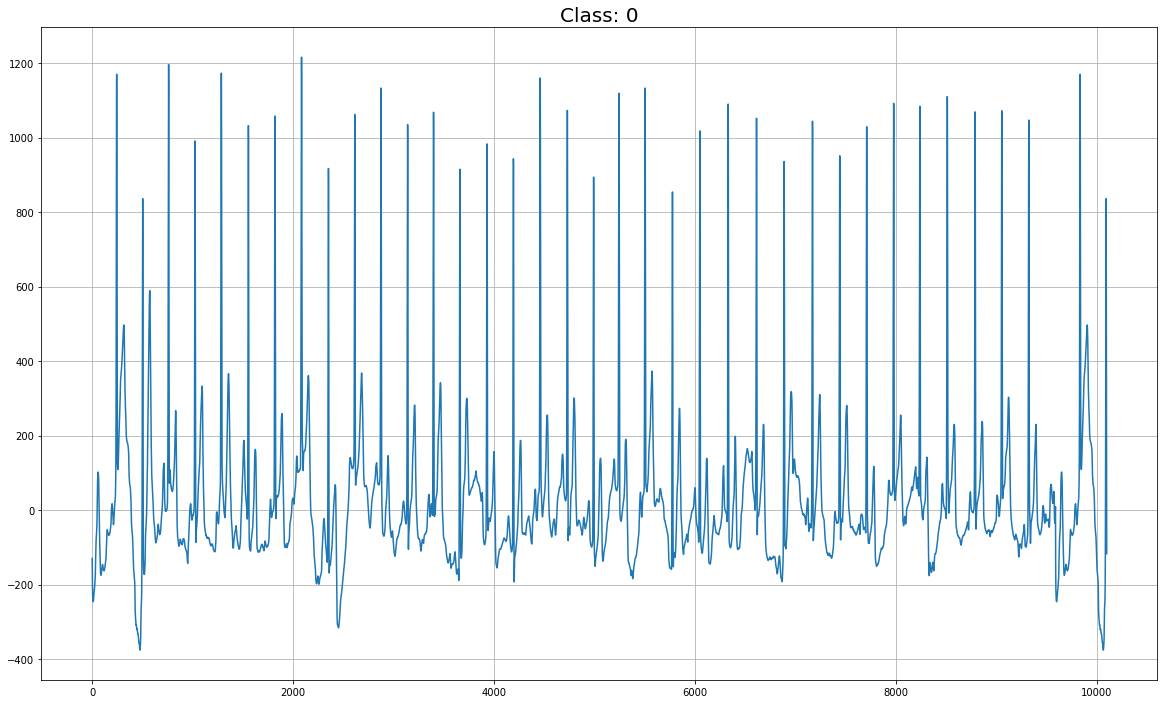

In [42]:
plt.figure(figsize=(20,12))
plot = plt.plot(X[1])
plt.grid()
label = bool_to_dec_array(data_labels)[1]
title = "Class: " + str(label)
plt.title(title, fontsize=20)

In [0]:
X_raw = X
X = (X - X.mean())/(X.std()) # Mean normalization
X = np.expand_dims(X, axis=2) # For Keras's data input size

Text(0.5, 1.0, 'Class: 0')

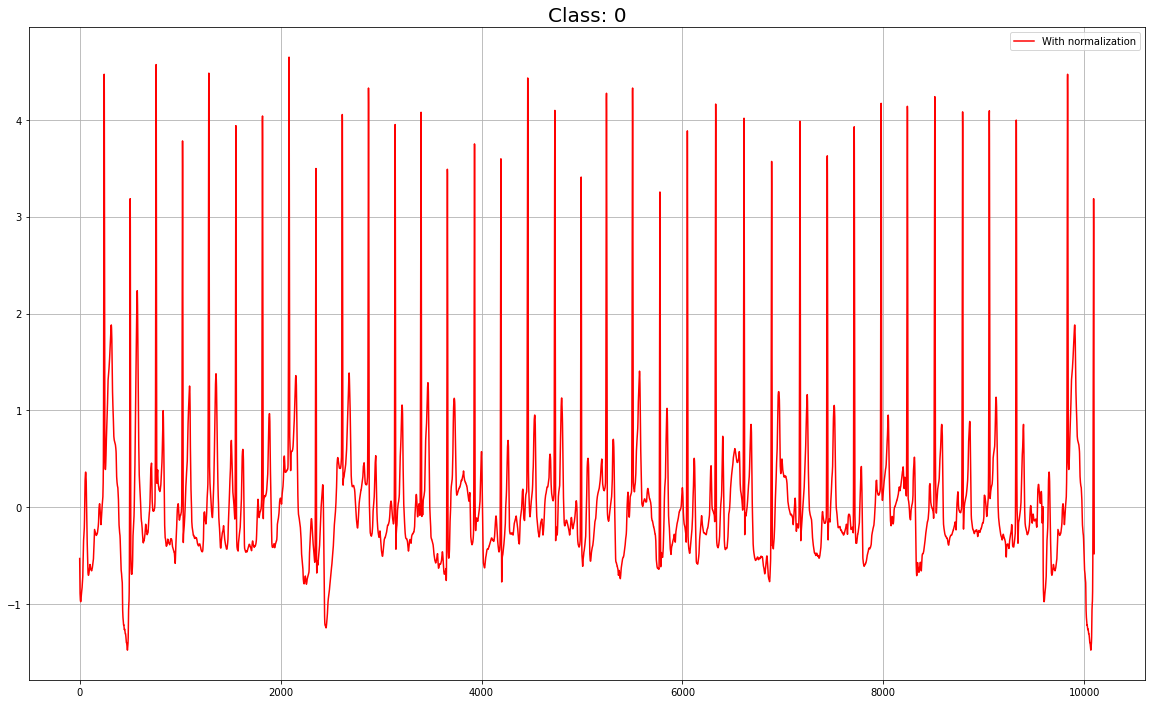

In [44]:
plt.figure(figsize=(20,12))
plot = plt.plot(X[1], color="red", label="With normalization")
plt.grid()
plt.legend()
title = "Class: " + str(label)
plt.title(title, fontsize=20)

Text(0.5, 1.0, 'Class: 0')

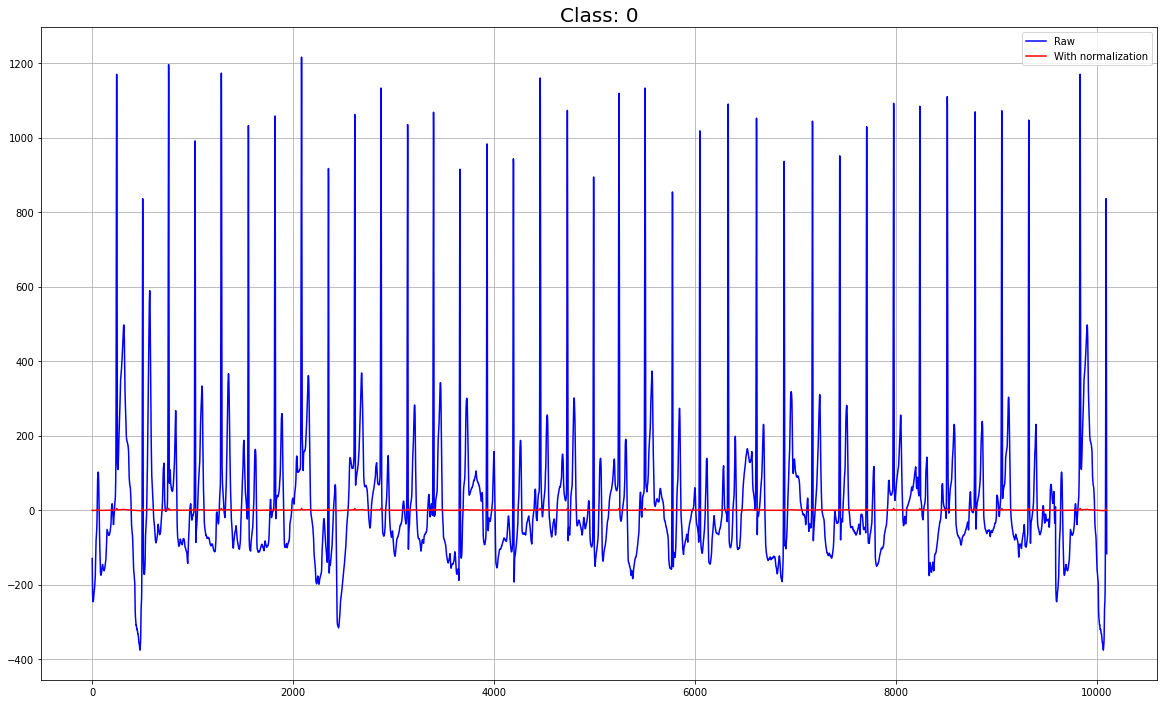

In [45]:
plt.figure(figsize=(20,12))
plot = plt.plot(X_raw[1], color="blue", label="Raw")
plot = plt.plot(X[1], color="red", label="With normalization")
plt.legend()
plt.grid()
title = "Class: " + str(label)
plt.title(title, fontsize=20)

In [0]:
X_norm = X
values = [i for i in range(size)]
permutations = np.random.permutation(values)
X = X[permutations, :]
data_labels = data_labels[permutations, :]

Text(0.5, 1.0, 'Class: 0')

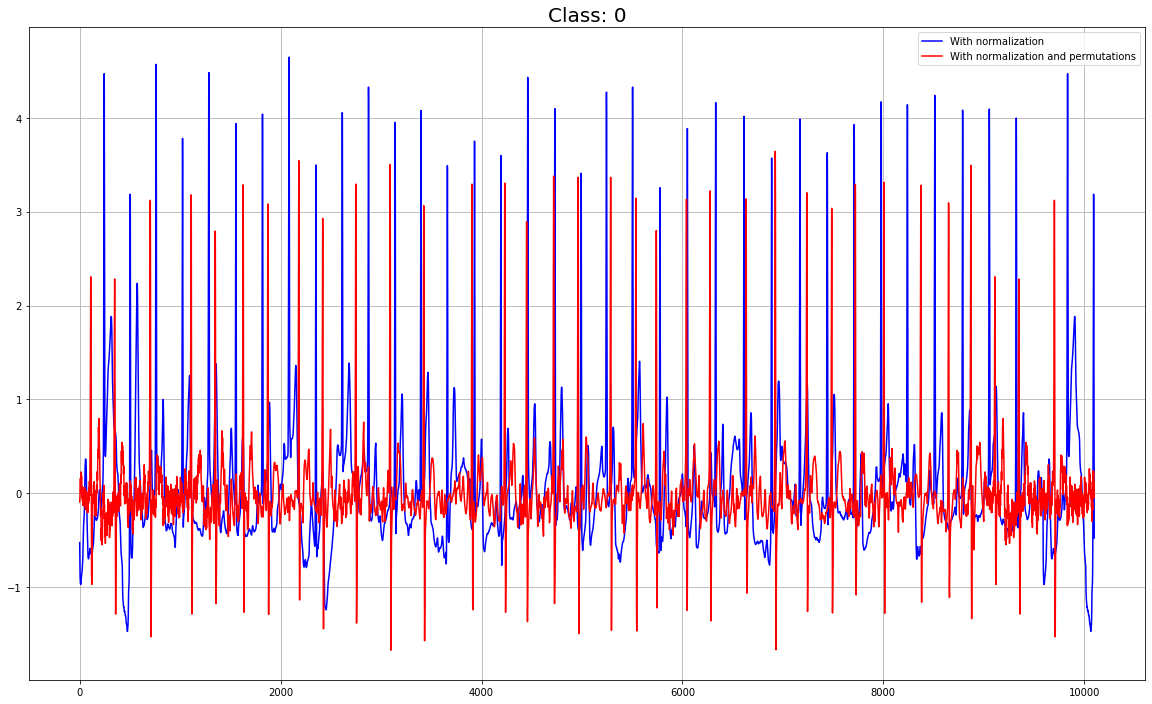

In [47]:
plt.figure(figsize=(20,12))
plot = plt.plot(X_norm[1], color="blue", label="With normalization")
plot = plt.plot(X[1], color="red", label="With normalization and permutations")
plt.legend()
plt.grid()
title = "Class: " + str(label)
plt.title(title, fontsize=20)

In [0]:
train_size = 0.9 
X_train = X[:int(train_size * size), :]
y_train = data_labels[:int(train_size * size), :]
X_val = X[int(train_size * size):, :]
y_val = data_labels[int(train_size * size):, :]

num_epochs = 500
batch_size = 275
verbose = 2

In [0]:
model = Sequential([
    Conv1D(128, 55, activation='relu', input_shape=(big, 1)),
    MaxPooling1D(10),
    Dropout(0.5),

    Conv1D(128, 25, activation='relu'),
    MaxPooling1D(5),
    Dropout(0.5),

    Conv1D(128, 10, activation='relu'),
    MaxPooling1D(5),
    Dropout(0.5),

    Conv1D(128, 5, activation='relu'),
    GlobalAveragePooling1D(),

    Dense(256, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),

    Dense(128, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),

    Dense(64, kernel_initializer='normal', activation='relu'),
    Dropout(0.5),

    Dense(number_of_classes, kernel_initializer='normal', activation='softmax'),
])

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 10046, 128)        7168      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1004, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1004, 128)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 980, 128)          409728    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 196, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 187, 128)         

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath='models/Best_model.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=num_epochs, verbose=verbose, shuffle=True, callbacks=[checkpointer]) 

Train on 7675 samples, validate on 853 samples
Epoch 1/2
 - 469s - loss: 1.1890 - accuracy: 0.5457 - val_loss: 1.0472 - val_accuracy: 0.6038
Epoch 2/2


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 470s - loss: 1.0021 - accuracy: 0.5889 - val_loss: 0.9587 - val_accuracy: 0.6038


In [54]:
predictions = model.predict(X_val)
score = accuracy_score(bool_to_dec_array(y_val), bool_to_dec_array(predictions))
print(f'Score: {score}')

Score: 0.6037514654161782


In [0]:
df = pd.DataFrame(bool_to_dec_array(predictions))

In [0]:
df.to_csv(path_or_buf='model/Predictions_' + str(format(score, '.4f')) + '.csv', index=None, header=None)